# Introduction 
This project serves as a re-introduction to data science and machine learning for me. I want to go back to the fundamentals, understanding why each move is made and how it impacts the project overall.

## Dataset

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
df = pd.read_csv("../datasets/predictive_maintenance.csv")

# EDA

In [3]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


#### Quick Observations on the data
- There is an identification number (UDI) that is unneccessary
- The Product ID column is also unnecessary for any analysis carried out as it is a unique identifier.
- This dataset has multiple target columns. Target and Failure Type. 

In [4]:
# Drop ID columns

df.drop(columns=['UDI','Product ID'], inplace=True)



In [5]:
df.rename(columns={'Type':'type', 'Air temperature [K]' :'air_temperature', 'Process temperature [K]':'process_temperature',
       'Rotational speed [rpm]':'rotational_speed', 'Torque [Nm]': 'torque', 'Tool wear [min]': 'tool_wear', 'Target': 'target',
       'Failure Type': 'failure_type'}, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   type                 10000 non-null  object 
 1   air_temperature      10000 non-null  float64
 2   process_temperature  10000 non-null  float64
 3   rotational_speed     10000 non-null  int64  
 4   torque               10000 non-null  float64
 5   tool_wear            10000 non-null  int64  
 6   target               10000 non-null  int64  
 7   failure_type         10000 non-null  object 
dtypes: float64(3), int64(3), object(2)
memory usage: 625.1+ KB


In [7]:
df['tool_wear'] = df['tool_wear'].astype('float64')
df['rotational_speed'] = df['rotational_speed'].astype('float64')

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
air_temperature,10000.0,300.00493,2.000259,295.3,298.3,300.1,301.5,304.5
process_temperature,10000.0,310.00556,1.483734,305.7,308.8,310.1,311.1,313.8
rotational_speed,10000.0,1538.77610,179.284096,1168.0,1423.0,1503.0,1612.0,2886.0
torque,10000.0,39.98691,9.968934,3.8,33.2,40.1,46.8,76.6
tool_wear,10000.0,107.95100,63.654147,0.0,53.0,108.0,162.0,253.0
target,10000.0,0.03390,0.180981,0.0,0.0,0.0,0.0,1.0


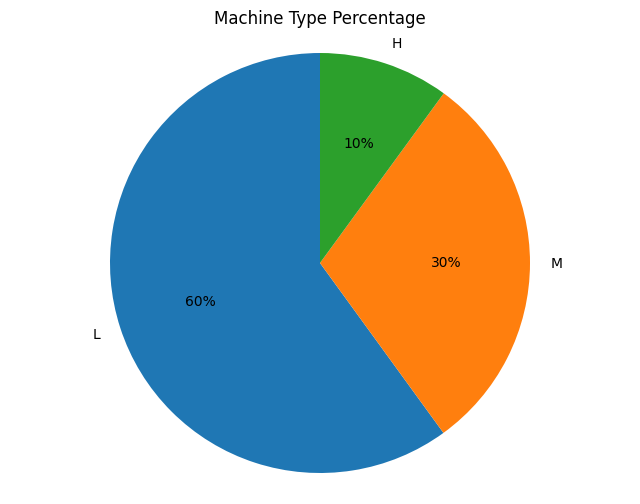

In [9]:
# Calculate the percentage of each type
type_counts = df['type'].value_counts()
type_percentage = 100 * type_counts / df['type'].shape[0]

# Prepare labels and values for the pie chart
labels = type_percentage.index
sizes = type_percentage.values

# Create a pie chart
plt.figure(figsize=(8, 6))  # Optional: Set figure size for better readability
plt.pie(sizes, labels=labels, colors=sns.color_palette('tab10')[:len(labels)], autopct='%.0f%%', startangle=90)
plt.title('Machine Type Percentage')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.

# Show the pie chart
plt.show()

This is a good enough split that does not indicate too much of oversampling. 

### Data Anomalies

Prior knowledge of this dataset confirms there are anomalies such as: 
- Values are classified as failure in the 'Target' variable but as No Failure in the 'failure_type' column.
- Values are classifed as Random Failures by 'Failure Type', but they are classifed as No failure by the 'Target Variable'

We have to eliminate them

In [10]:
df['failure_type'].value_counts()

failure_type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

In [11]:
df_failure = df[df['target'] == 1]
df_failure['failure_type'].value_counts()

failure_type
Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
No Failure                    9
Name: count, dtype: int64

This confirms the first anomaly and those values will be dropped. 

In [12]:
# Identify indices of rows with 'No Failure'
position_wrong_failures = df_failure[df_failure['failure_type'] == 'No Failure'].index

# Drop these indices from the original DataFrame
df.drop(position_wrong_failures, axis=0, inplace=True)

In [13]:
df_failure = df[df['target'] == 0]
df_failure['failure_type'].value_counts()

failure_type
No Failure         9643
Random Failures      18
Name: count, dtype: int64

In [14]:
#get the position of these random failures
position_wrong_random_failures = df_failure[df_failure['failure_type'] == 'Random Failures'].index

#drop the columns
df.drop(position_wrong_random_failures, axis=0, inplace=True)

In [15]:
df.reset_index(inplace=True, drop=True)

27 data points out of 10000 will be fine. 0.27%

### Outlier Inspection

In [16]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
air_temperature,9973.0,300.003259,2.000548,295.3,298.3,300.1,301.5,304.5
process_temperature,9973.0,310.004031,1.483692,305.7,308.8,310.1,311.1,313.8
rotational_speed,9973.0,1538.893212,179.412171,1168.0,1423.0,1503.0,1612.0,2886.0
torque,9973.0,39.978993,9.966805,3.8,33.2,40.1,46.7,76.6
tool_wear,9973.0,107.921087,63.649152,0.0,53.0,108.0,162.0,253.0
target,9973.0,0.033089,0.178879,0.0,0.0,0.0,0.0,1.0


The max of `rotational_speed`, `torque` and `tool_wear` being significantly different from could indicate outliers

/var/folders/bq/m6w531zj0x1d5w35rqn1s5fh0000gn/T/ipykernel_58790/1646715148.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=i, ax=axes[1, j], palette=['#976EBD'])
/var/folders/bq/m6w531zj0x1d5w35rqn1s5fh0000gn/T/ipykernel_58790/1646715148.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=i, ax=axes[1, j], palette=['#976EBD'])
/var/folders/bq/m6w531zj0x1d5w35rqn1s5fh0000gn/T/ipykernel_58790/1646715148.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=i, ax=axes[1, j], palette=['#976EBD'])
/var/folde

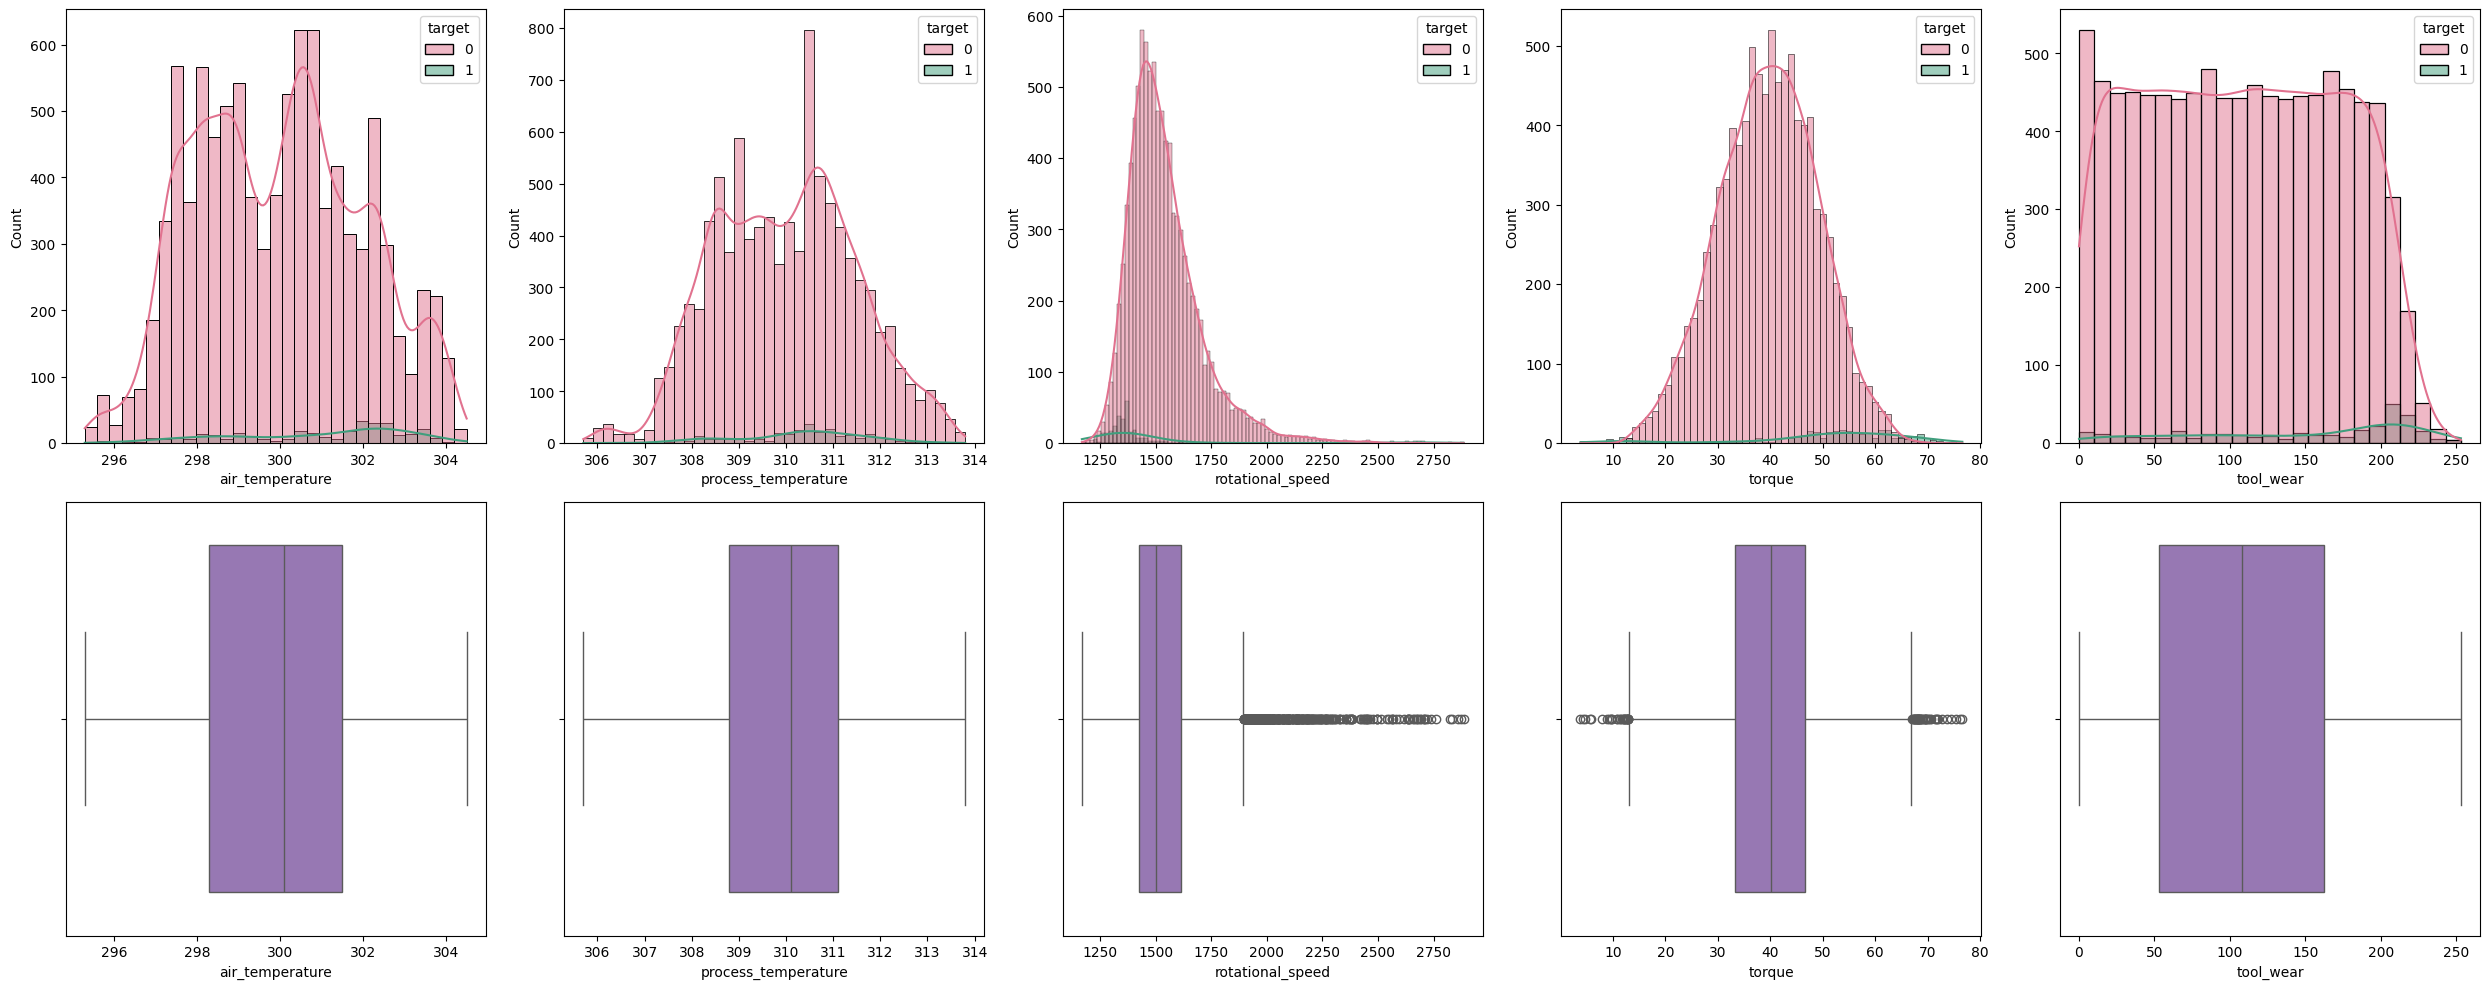

In [17]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 5, figsize=[25, 10])
j = 0
colors = ['#E1728F', '#409E7D']

# List of features to plot
features = ['air_temperature', 'process_temperature', 'rotational_speed', 'torque', 'tool_wear']

for i in features:
    # Histogram with KDE
    sns.histplot(data=df, x=i, kde=True, ax=axes[0, j], hue='target', palette=colors)
    
    # Boxplot
    sns.boxplot(data=df, x=i, ax=axes[1, j], palette=['#976EBD'])
    
    j += 1

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

There are obviously outliers in the data to be dealt with later

# Preprocessing

### Data Augmentation

There were class balances as we could see which is a huge problem in machine learning problems. Some ways of solving class imbalances involve: 

- Under-sampling by deleting some data points from the majority class.
- Over-Sampling by copying rows of data resulting in the minority class.
- Over-Sampling with SMOTE (Synthetic Minority Oversampling Technique).

Failures percentage in data: 3.31
Percentage of no failure in data: 96.69


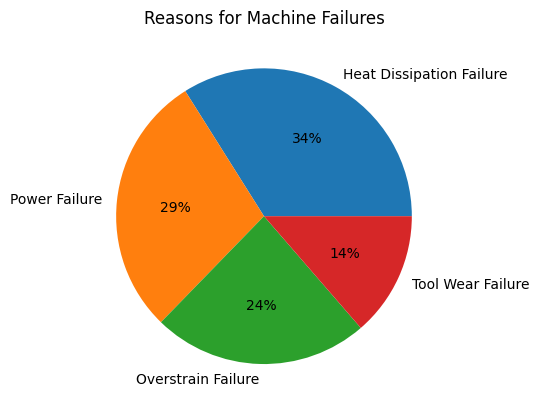

In [18]:
df_fail = df[df['failure_type'] != 'No Failure']

# Calculate failure type percentages
failure_counts = df_fail['failure_type'].value_counts()
df_fail_percentage = 100 * failure_counts / failure_counts.sum()

# Calculate overall failure percentage in the data
total_failures = df['target'].sum()
total_records = len(df)
overall_failure_percentage = round(100 * total_failures / total_records, 2)

# Print overall failure percentage
print('Failures percentage in data:', overall_failure_percentage)
print('Percentage of no failure in data:', 100 - overall_failure_percentage)

# Create a pie plot for failure causes
plt.title('Reasons for Machine Failures')
plt.pie(
    x=df_fail_percentage,
    labels=df_fail_percentage.index,
    colors=sns.color_palette('tab10')[0:4],
    autopct='%.0f%%'
)
plt.show()

96% of the data is a huge imbalance and we work to correct using SMOTE analysis. A link to an article written on the reasoning behind using that form of data augmentation will be included here.

In [19]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC

# Determine the number of 'No Failure' instances, which should represent 80% of the desired length
number_no_failure = df['failure_type'].value_counts()['No Failure']
desired_length = round(number_no_failure / 0.8)

# Calculate the number of samples needed for each failure type
samples_per_class = round((desired_length - number_no_failure) / 4)  # Distributing among four failure types

# Define the resampling strategy
resampling_strategy = {
    'No Failure': number_no_failure,
    'Overstrain Failure': samples_per_class,
    'Heat Dissipation Failure': samples_per_class,
    'Power Failure': samples_per_class,
    'Tool Wear Failure': samples_per_class
}

# Initialize the SMOTENC instance for categorical features
smote = SMOTENC(categorical_features=[0, 7], sampling_strategy=resampling_strategy, random_state=0)

# Resample the DataFrame
df_resampled, y_resampled = smote.fit_resample(df, df['failure_type'])

Percentage increment of observations after oversampling: 20.88
SMOTE Resampled Failures percentage: 20.01


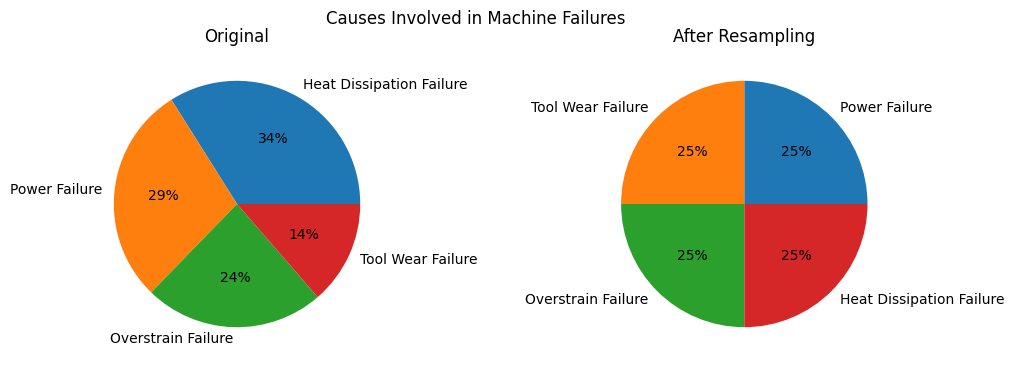

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify failures in the resampled DataFrame
failure_indices_resampled = df_resampled[df_resampled['failure_type'] != 'No Failure'].index
df_res_fail = df_resampled.loc[failure_indices_resampled]

# Calculate failure type percentages in the resampled DataFrame
failure_counts_resampled = df_res_fail['failure_type'].value_counts()
fail_res_percentage = 100 * failure_counts_resampled / df_res_fail.shape[0]

# Calculate percentage increment of observations after oversampling
percentage_increment = round((df_resampled.shape[0] - df.shape[0]) * 100 / df.shape[0], 2)

# Calculate percentage of failures in the resampled DataFrame
smote_resampled_failures_percentage = round(df_res_fail.shape[0] * 100 / df_resampled.shape[0], 2)

# Print results
print('Percentage increment of observations after oversampling:', percentage_increment)
print('SMOTE Resampled Failures percentage:', smote_resampled_failures_percentage)

# Create pie plots for failure causes
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
fig.suptitle('Causes Involved in Machine Failures')

# Original failures percentage
axs[0].pie(
    x=df_fail_percentage,
    labels=df_fail_percentage.index,
    colors=sns.color_palette('tab10')[0:4],
    autopct='%.0f%%'
)
axs[0].title.set_text('Original')

# Resampled failures percentage
axs[1].pie(
    x=fail_res_percentage,
    labels=fail_res_percentage.index,
    colors=sns.color_palette('tab10')[0:4],
    autopct='%.0f%%'
)
axs[1].title.set_text('After Resampling')

# Show plots
plt.show()

### Feature Scaling and Encoding

Scaling data is a difficult process as you have to choose the proper scaler to use 
- Use MinMaxScaler as your default
- Use RobustScaler if you have outliers and can handle a larger range
- Use StandardScaler if you need normalized features
- Use Normalizer sparingly - it normalizes rows, not columns

In [21]:
num_features = [feature for feature in features if df[feature].dtype=='float64']

In [22]:
from sklearn.preprocessing import StandardScaler

# Create an instance of StandardScaler
scaler = StandardScaler()

# Define dictionaries for encoding categorical variables
type_encoding = {'L': 0, 'M': 1, 'H': 2}
cause_encoding = {
    'No Failure': 0,
    'Power Failure': 1,
    'Overstrain Failure': 2,
    'Heat Dissipation Failure': 3,
    'Tool Wear Failure': 4
}
# Create a copy of the DataFrame to avoid modifying the original
df_preprocessed = df_resampled.copy()

# Encoding categorical variables without using inplace
df_preprocessed['type'] = df_preprocessed['type'].replace(to_replace=type_encoding)
df_preprocessed['failure_type'] = df_preprocessed['failure_type'].replace(to_replace=cause_encoding)

# Scaling numeric features
df_preprocessed[num_features] = scaler.fit_transform(df_preprocessed[num_features])

/var/folders/bq/m6w531zj0x1d5w35rqn1s5fh0000gn/T/ipykernel_58790/2809487511.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_preprocessed['type'] = df_preprocessed['type'].replace(to_replace=type_encoding)
/var/folders/bq/m6w531zj0x1d5w35rqn1s5fh0000gn/T/ipykernel_58790/2809487511.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_preprocessed['failure_type'] = df_preprocessed['failure_type'].replace(to_replace=cause_encoding)


In [23]:
from sklearn.decomposition import PCA

# Create PCA instance with the number of components equal to the number of features
pca = PCA(n_components=len(num_features))

# Fit PCA and transform the data, creating a DataFrame for the principal components
X_pca = pd.DataFrame(
    data=pca.fit_transform(df_preprocessed[num_features]),
    columns=[f'PC{i+1}' for i in range(len(num_features))]
)

# Calculate the explained variance ratio as a percentage
var_exp = pd.Series(
    data=100 * pca.explained_variance_ratio_,
    index=[f'PC{i+1}' for i in range(len(num_features))]
)

# Print the explained variance ratio per component
print('Explained variance ratio per component:')
print(round(var_exp, 2), sep='\n')

# Print the sum of the explained variance ratio for the first three components
explained_variance_three_components = round(var_exp.values[:3].sum(), 2)
print(f'Explained variance ratio with 3 components: {explained_variance_three_components}')

Explained variance ratio per component:
PC1    37.76
PC2    36.73
PC3    19.84
PC4     3.08
PC5     2.58
dtype: float64
Explained variance ratio with 3 components: 94.34


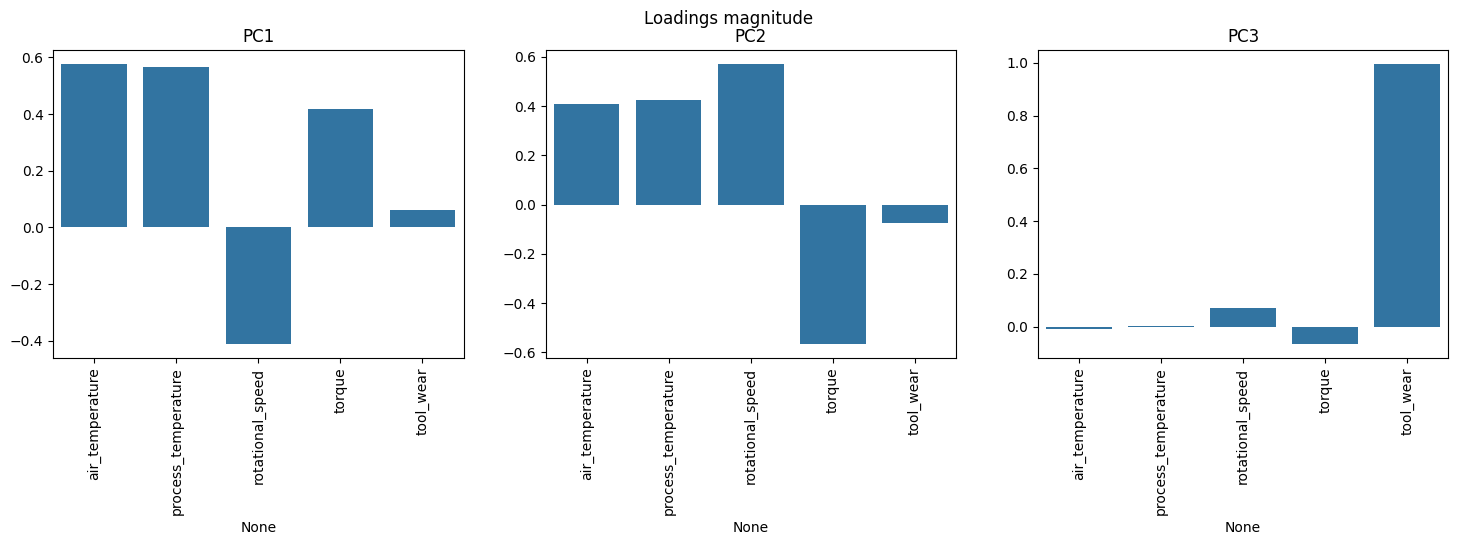

In [24]:
# PCA for Data visualization
pca3 = PCA(n_components=3)
X_pca3 = pd.DataFrame(
    data=pca3.fit_transform(df_preprocessed[num_features]),
      columns=['PC1','PC2','PC3'])

fig, axs = plt.subplots(ncols=3, figsize=(18,4))
fig.suptitle('Loadings magnitude')

pca_loadings = pd.DataFrame(data=pca3.components_, columns=num_features)
for j in range(3):
    ax = axs[j]
    sns.barplot(ax=ax, x=pca_loadings.columns, y=pca_loadings.values[j])
    ax.tick_params(axis='x', rotation=90)
    ax.title.set_text('PC'+str(j+1))
plt.show()

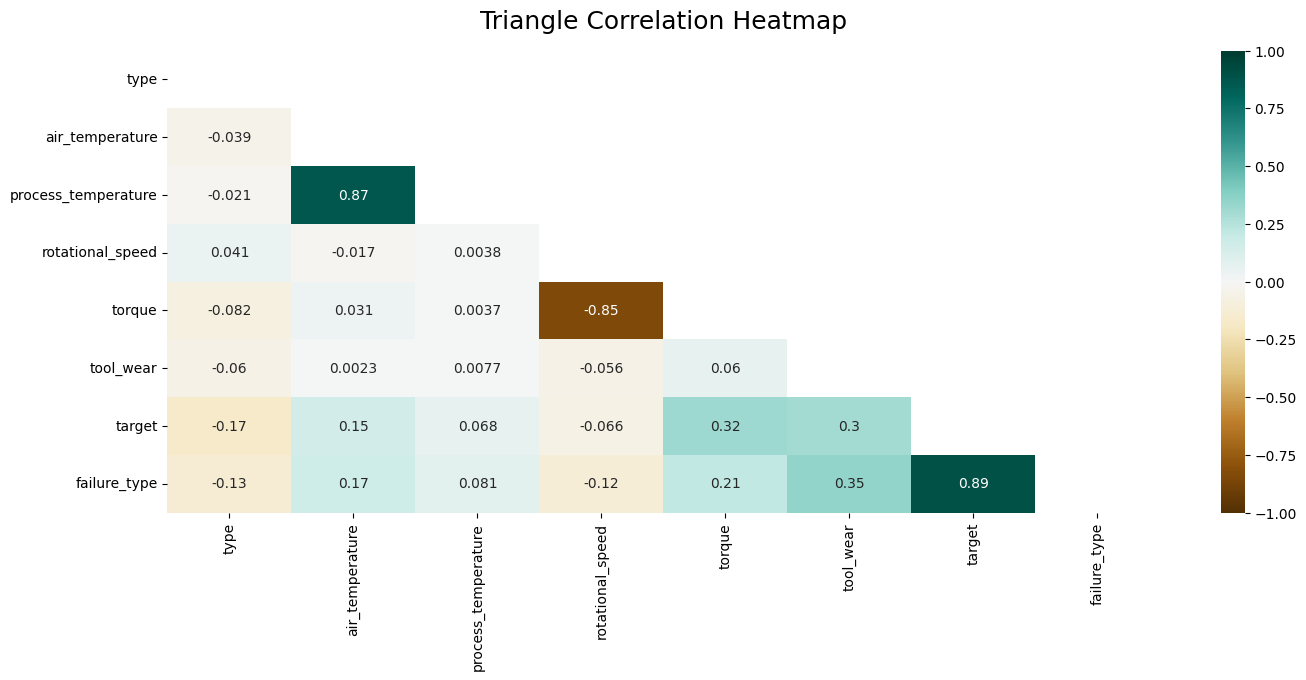

In [25]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df_preprocessed.corr(), dtype=bool))
heatmap = sns.heatmap(df_preprocessed.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

# Modelling 

This dataset allows us to perform the two different types of classification. Binary and Multi-class classification. 

In [26]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.inspection import permutation_importance
import time

# train-validation-test split
X, y = df_preprocessed[features], df_preprocessed[['target','failure_type']]
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, stratify=df_preprocessed['failure_type'], random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.11, stratify=y_trainval['failure_type'], random_state=0)

When working with ML models, the chances you are going to do the same activity repeatedly means you should define functions to avoid repetition

For this, we will define functions to: 
- Evaluate the prediction 
- Search for the best parameters 
- Makes predictions and evaluate the predictions 
- Fit the models on multiple classifiers

In [27]:
def eval_preds(model, X, y_true, y_pred, task):
    """
    Evaluate predictions made by a classification model.

    Parameters:
    - model: The trained machine learning model.
    - X: Features used for making predictions.
    - y_true: True labels (as a DataFrame).
    - y_pred: Predicted labels by the model.
    - task: Type of classification ('binary' or 'multi_class').

    Returns:
    - cm: Confusion matrix.
    - metrics: A Series containing accuracy, AUC, F1 score, and F2 score.
    """
    
    if task == 'binary':
        # Extract true labels for binary classification
        y_true = y_true['target']
        
        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Get predicted probabilities for the positive class
        proba = model.predict_proba(X)[:, 1]
        
        # Calculate metrics
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, proba)
        f1 = f1_score(y_true, y_pred, pos_label=1)
        f2 = fbeta_score(y_true, y_pred, pos_label=1, beta=2)
    
    elif task == 'multi_class':
        # Extract true labels for multi-class classification
        y_true = y_true['failure_type']
        
        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Get predicted probabilities for all classes
        proba = model.predict_proba(X)
        
        # Calculate metrics
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, proba, multi_class='ovr', average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        f2 = fbeta_score(y_true, y_pred, beta=2, average='weighted')
    
    # Compile metrics into a Series
    metrics = pd.Series(data={'ACC': acc, 'AUC': auc, 'F1': f1, 'F2': f2})
    
    # Round metrics to three decimal places
    metrics = metrics.round(3)
    
    return cm, metrics

In [28]:
def tune_and_fit(clf, X, y, params, task):
    """
    Perform hyperparameter tuning and fit the model using GridSearchCV.

    Parameters:
    - clf: Classifier model instance (e.g., RandomForestClassifier).
    - X: Features used for training the model.
    - y: Target labels (as a DataFrame).
    - params: Dictionary of hyperparameters for tuning.
    - task: Type of classification ('binary' or 'multi_class').

    Returns:
    - grid_model: The GridSearchCV object with the best model fitted.
    """
    
    # Initialize scoring based on the task
    if task == 'binary':
        f2_scorer = make_scorer(fbeta_score, pos_label=1, beta=2)
    elif task == 'multi_class':
        f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
    else:
        raise ValueError("Task must be 'binary' or 'multi_class'.")

    # Start timing the training process
    start_time = time.time()
    
    # Setup GridSearchCV
    grid_model = GridSearchCV(clf, param_grid=params, cv=5, scoring=f2_scorer)
    print("Grid search started")
    
    # Fit the model based on the task
    if task == 'binary':
        grid_model.fit(X, y['target'])
    elif task == 'multi_class':
        grid_model.fit(X, y['failure_type'])
    
    # Output the best parameters found
    print('Best parameters:', grid_model.best_params_)
    
    # Calculate training time
    train_time = time.time() - start_time
    mins = int(train_time // 60)
    seconds = round(train_time - mins * 60)
    
    print(f'Training time: {mins}m {seconds}s')
    
    return grid_model

In [29]:
def predict_and_evaluate(fitted_models, X, y_true, clf_str, task):
    """
    Make predictions and evaluate the performance of multiple classifiers.

    Parameters:
    - fitted_models: List of trained classifier models.
    - X: Feature set for making predictions.
    - y_true: True labels (as a DataFrame).
    - clf_str: List of classifier names corresponding to the models.
    - task: Type of classification ('binary' or 'multi_class').

    Returns:
    - y_pred: DataFrame of predictions for each classifier.
    - cm_dict: Dictionary containing confusion matrices for each classifier.
    - metrics: DataFrame of evaluation metrics for each classifier.
    """
    
    # Initialize confusion matrix dictionary and metrics DataFrame
    cm_dict = {key: np.nan for key in clf_str}
    metrics = pd.DataFrame(columns=clf_str)
    y_pred = pd.DataFrame(columns=clf_str)

    # Loop through each fitted model and its corresponding name
    for fit_model, model_name in zip(fitted_models, clf_str):
        # Make predictions
        y_pred[model_name] = fit_model.predict(X)
        
        # Evaluate predictions based on the task
        cm, scores = eval_preds(fit_model, X, y_true, y_pred[model_name], task)
        
        # Store confusion matrix and metrics
        cm_dict[model_name] = cm
        metrics[model_name] = scores
    
    return y_pred, cm_dict, metrics

In [30]:
def fit_models(clf, clf_str, X_train, X_val, y_train, y_val):
    """
    Fit multiple classifiers and evaluate their performance.

    Parameters:
    - clf: List of classifier model instances.
    - clf_str: List of classifier names corresponding to the models.
    - X_train: Feature set for training the models.
    - X_val: Feature set for validating the models.
    - y_train: True labels for the training data (as a DataFrame).
    - y_val: True labels for the validation data (as a DataFrame).

    Returns:
    - metrics: DataFrame containing evaluation metrics for each classifier.
    """
    
    # Initialize an empty DataFrame to store metrics
    metrics = pd.DataFrame(columns=clf_str)

    # Loop through each model and its corresponding name
    for model, model_name in zip(clf, clf_str):
        # Fit the model on the training data
        model.fit(X_train, y_train['target'])
        
        # Make predictions on the validation data
        y_val_pred = model.predict(X_val)
        
        # Evaluate predictions and store metrics
        metrics[model_name] = eval_preds(model, X_val, y_val, y_val_pred, 'binary')[1]
    
    return metrics

From the earlier analysis on the features, we perform some further augmentation and testing on the features to understand whether we get better results from manipulating columns. 

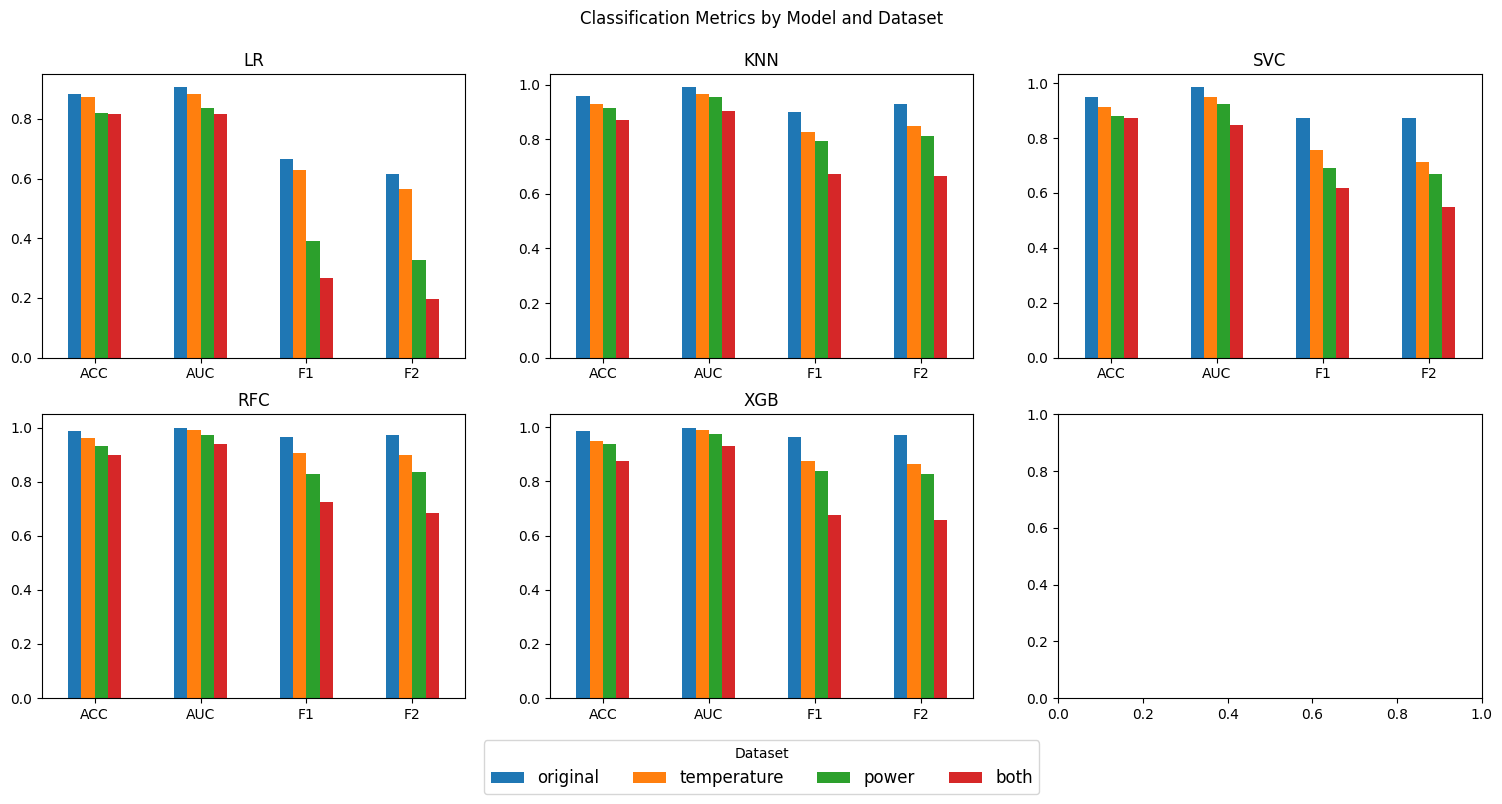

In [31]:
# Initialize classifiers
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(probability=True),
    RandomForestClassifier(),
    XGBClassifier()
]

classifier_names = ['LR', 'KNN', 'SVC', 'RFC', 'XGB'] 

# Fit models on various datasets and collect metrics
metrics_raw = fit_models(classifiers, classifier_names, X_train, X_val, y_train, y_val)

# Feature engineering for temperature products
XX_train_temp = X_train.drop(columns=['process_temperature', 'air_temperature'])
XX_val_temp = X_val.drop(columns=['process_temperature', 'air_temperature'])
XX_train_temp['temperature'] = X_train['process_temperature'] * X_train['air_temperature']
XX_val_temp['temperature'] = X_val['process_temperature'] * X_val['air_temperature']
metrics_temp = fit_models(classifiers, classifier_names, XX_train_temp, XX_val_temp, y_train, y_val)

# Feature engineering for power products
XX_train_power = X_train.drop(columns=['rotational_speed', 'torque'])
XX_val_power = X_val.drop(columns=['rotational_speed', 'torque'])
XX_train_power['power'] = X_train['rotational_speed'] * X_train['torque']
XX_val_power['power'] = X_val['rotational_speed'] * X_val['torque']
metrics_power = fit_models(classifiers, classifier_names, XX_train_power, XX_val_power, y_train, y_val)

# Feature engineering for both temperature and power products
XX_train_both = X_train.drop(columns=['process_temperature', 'air_temperature', 'rotational_speed', 'torque'])
XX_val_both = X_val.drop(columns=['process_temperature', 'air_temperature', 'rotational_speed', 'torque'])
XX_train_both['temperature'] = X_train['process_temperature'] * X_train['air_temperature']
XX_val_both['temperature'] = X_val['process_temperature'] * X_val['air_temperature']
XX_train_both['power'] = X_train['rotational_speed'] * X_train['torque']
XX_val_both['power'] = X_val['rotational_speed'] * X_val['torque']
metrics_both = fit_models(classifiers, classifier_names, XX_train_both, XX_val_both, y_train, y_val)

# Visualization of classification metrics
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
fig.suptitle('Classification Metrics by Model and Dataset')

# Loop through classifiers and plot metrics
for j, model_name in enumerate(classifier_names):
    ax = axs[j // 3, j % 3]
    model_metrics = pd.DataFrame(data=[
        metrics_raw[model_name],
        metrics_temp[model_name],
        metrics_power[model_name],
        metrics_both[model_name]
    ])
    model_metrics.index = ['original', 'temperature', 'power', 'both']
    model_metrics.transpose().plot(ax=ax, kind='bar', rot=0)
    ax.title.set_text(model_name)
    ax.get_legend().remove()

# Adjust layout and add legend
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)
axs.flatten()[-2].legend(title='Dataset', loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4, fontsize=12)
plt.show()

From this, we see the dataset performs best when it is on its own and uninterrupted by any feature engineering and whatnot. So we use it without any modifications.

### Logistic Regression as the benchmark

Validation set metrics:
ACC    0.883
AUC    0.905
F1     0.667
F2     0.616
dtype: float64
Test set metrics:
ACC    0.878
AUC    0.910
F1     0.635
F2     0.568
dtype: float64


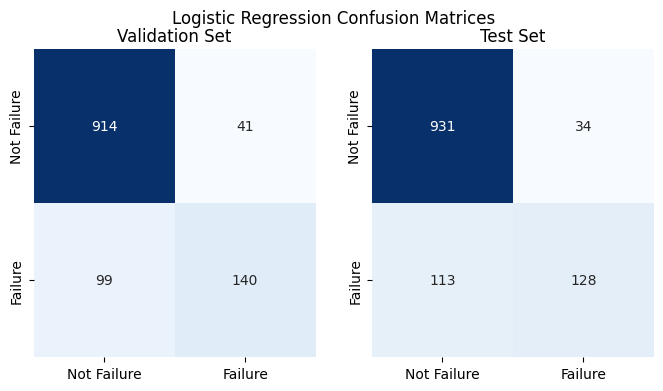

,feature,odds
3,torque,17.568596
2,rotational_speed,9.596900
0,air_temperature,4.538966
4,tool_wear,3.556176
1,process_temperature,0.346402


In [32]:
# Fit Logistic Regression Model
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train['target'])

# Make Predictions
y_val_lr = lr.predict(X_val)
y_test_lr = lr.predict(X_test)

# Evaluate Predictions
cm_val_lr, metrics_val_lr = eval_preds(lr, X_val, y_val, y_val_lr, 'binary')
cm_test_lr, metrics_test_lr = eval_preds(lr, X_test, y_test, y_test_lr, 'binary')

# Display Metrics
print('Validation set metrics:', metrics_val_lr, sep='\n')
print('Test set metrics:', metrics_test_lr, sep='\n')

# Confusion Matrix Labels
cm_labels = ['Not Failure', 'Failure']
cm_lr = [cm_val_lr, cm_test_lr]

# Visualize Confusion Matrices
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
fig.suptitle('Logistic Regression Confusion Matrices')

for j, title in enumerate(['Validation Set', 'Test Set']):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_lr[j], annot=True, fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(title)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)

plt.show()

# Calculate Odds Ratios for Interpretation
odds = np.exp(lr.coef_[0])
odds_df = pd.DataFrame({'feature': X_train.columns, 'odds': odds}).sort_values(by='odds', ascending=False)

# Display Odds DataFrame
odds_df

In [33]:
# Initialize Classifiers
knn = KNeighborsClassifier()
svc = SVC()
rfc = RandomForestClassifier()
xgb = XGBClassifier() 

# List of classifiers and their names
classifiers = [knn, svc, rfc, xgb]
classifier_names = ['KNN', 'SVC', 'RFC', 'XGB']

# Define Parameter Grids for GridSearch
knn_params = {'n_neighbors': [1, 3, 5, 8, 10]}
svc_params = {
    'C': [1, 10, 100],
    'gamma': [0.1, 1],
    'kernel': ['rbf'],
    'probability': [True],
    'random_state': [0]
}
rfc_params = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [5, 7, 10],
    'random_state': [0]
}
xgb_params = {
    'n_estimators': [300, 500, 700],
    'max_depth': [5, 7],
    'learning_rate': [0.01, 0.1],
    'objective': ['binary:logistic']
}

# Create a Series to associate classifiers with their parameter grids
params = pd.Series(data=[knn_params, svc_params, rfc_params, xgb_params], index=classifiers)

# Hyperparameter Tuning with GridSearch
print('GridSearch start')
fitted_models_binary = []

# Iterate over each classifier for training and tuning
for model, model_name in zip(classifiers, classifier_names):
    print(f'Training {model_name}')
    fitted_model = tune_and_fit(model, X_train, y_train, params[model], 'binary')
    fitted_models_binary.append(fitted_model)

print('GridSearch completed.')

GridSearch start
Training KNN
Grid search started


/Users/admin/Documents/ml-portfolio/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'n_neighbors': 1}
Training time: 0m 2s
Training SVC
Grid search started


/Users/admin/Documents/ml-portfolio/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf', 'probability': True, 'random_state': 0}
Training time: 1m 20s
Training RFC
Grid search started
Best parameters: {'max_depth': 10, 'n_estimators': 700, 'random_state': 0}
Training time: 2m 51s
Training XGB
Grid search started
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 700, 'objective': 'binary:logistic'}
Training time: 0m 52s
GridSearch completed.


I ran into a problem in the cell above and had to downgrade my sklearn from 1.6.1 to 1.5.2 to fix it, but from comments online, this issue will be fixed in 1.7

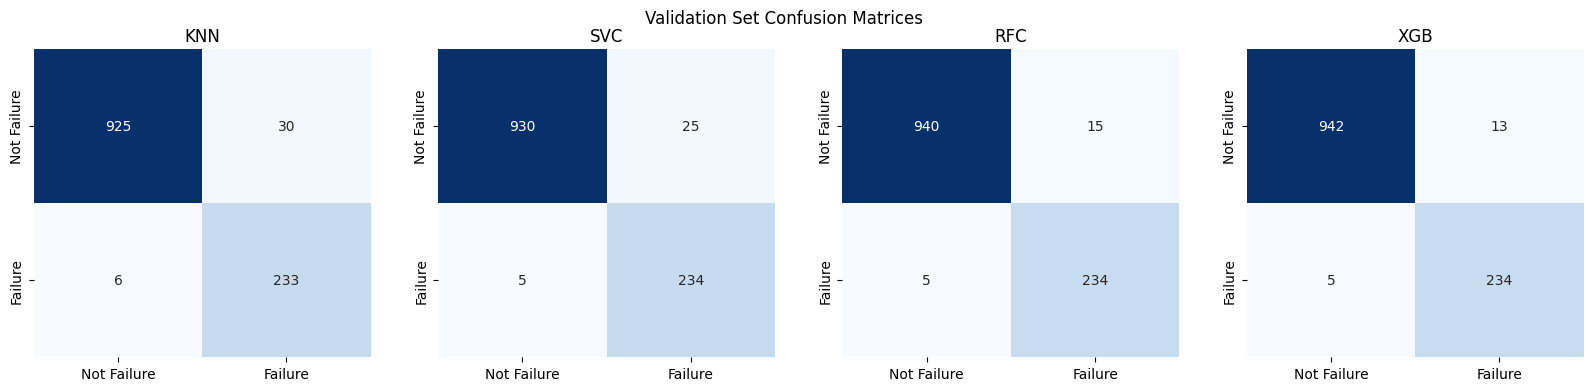

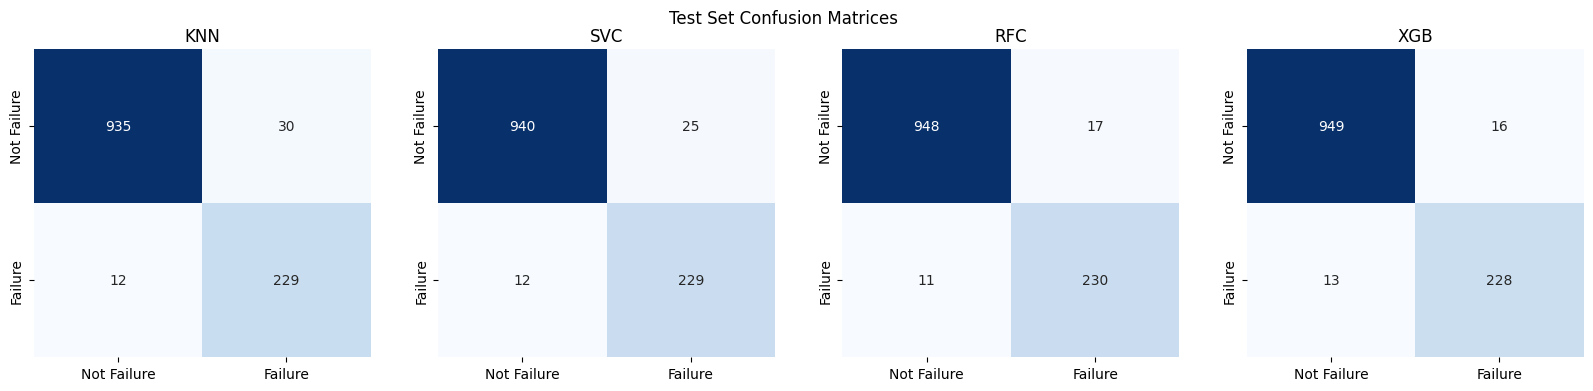


Validation scores:
       KNN    SVC    RFC    XGB
ACC  0.970  0.975  0.983  0.985
AUC  0.972  0.995  0.998  0.998
F1   0.928  0.940  0.959  0.963
F2   0.956  0.963  0.971  0.973
Test scores:
       KNN    SVC    RFC    XGB
ACC  0.965  0.969  0.977  0.976
AUC  0.960  0.992  0.996  0.998
F1   0.916  0.925  0.943  0.940
F2   0.936  0.940  0.950  0.944


In [34]:
# Set task type for evaluation
task = 'binary'

# Evaluate models on validation and test sets
y_pred_val, cm_dict_val, metrics_val = predict_and_evaluate(
    fitted_models_binary, X_val, y_val, classifier_names, task
)
y_pred_test, cm_dict_test, metrics_test = predict_and_evaluate(
    fitted_models_binary, X_test, y_test, classifier_names, task
)

# Visualize Validation Set Confusion Matrices
fig, axs = plt.subplots(ncols=4, figsize=(20, 4))
fig.suptitle('Validation Set Confusion Matrices')

for j, model_name in enumerate(classifier_names):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_val[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)

plt.show()

# Visualize Test Set Confusion Matrices
fig, axs = plt.subplots(ncols=4, figsize=(20, 4))
fig.suptitle('Test Set Confusion Matrices')

for j, model_name in enumerate(classifier_names):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_test[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)

plt.show()

# Print Evaluation Metrics
print('\nValidation scores:', metrics_val, sep='\n')
print('Test scores:', metrics_test, sep='\n')

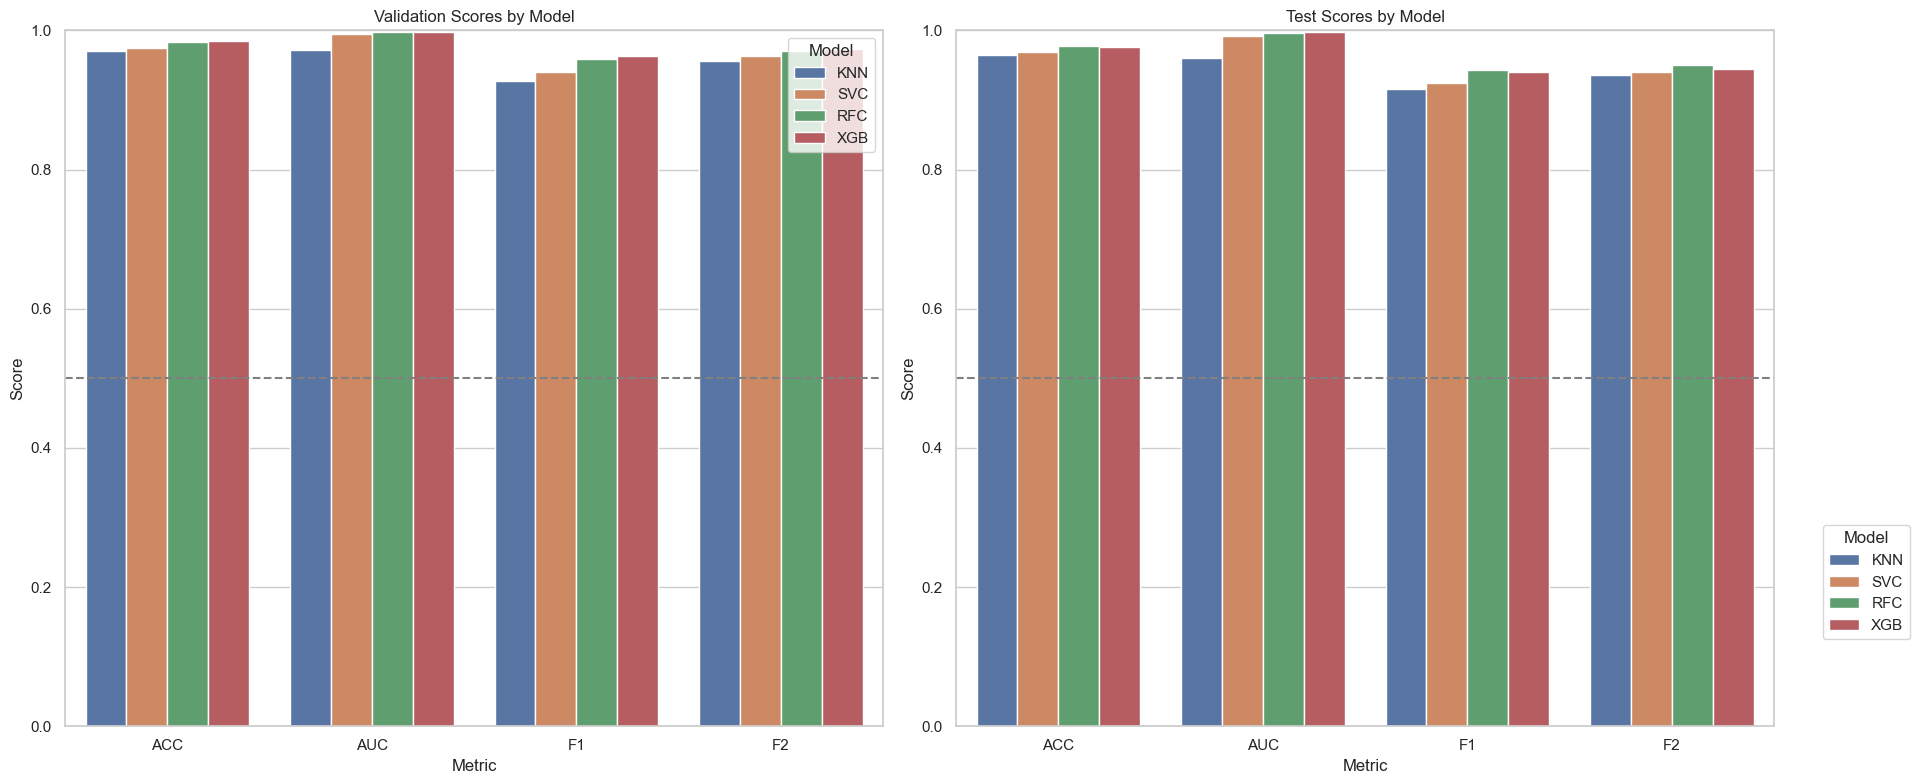

In [35]:
val_df_melted = metrics_val.reset_index().melt(id_vars='index', var_name='Model', value_name='Score')
test_df_melted = metrics_test.reset_index().melt(id_vars='index', var_name='Model', value_name='Score')

# Rename the index column for clarity
val_df_melted.rename(columns={'index': 'Metric'}, inplace=True)
test_df_melted.rename(columns={'index': 'Metric'}, inplace=True)

# Set the style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(18, 8))

# Validation Scores
plt.subplot(1, 2, 1)
sns.barplot(x='Metric', y='Score', hue='Model', data=val_df_melted)
plt.title('Validation Scores by Model')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('Metric')
plt.axhline(0.5, color='gray', linestyle='--')  # Optional: line for reference

# Test Scores
plt.subplot(1, 2, 2)
sns.barplot(x='Metric', y='Score', hue='Model', data=test_df_melted)
plt.title('Test Scores by Model')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('Metric')
plt.axhline(0.5, color='gray', linestyle='--') 

# Adjust layout
plt.tight_layout()
plt.legend(title='Model', bbox_to_anchor=(1.05, 0.3), loc='upper left')
plt.show()



The decrease in scores from the validation to the test set is not that much indicating there was minimal overfitting. 

XGboost also looks like the best model with slightly higher scores than RFC which is a close second

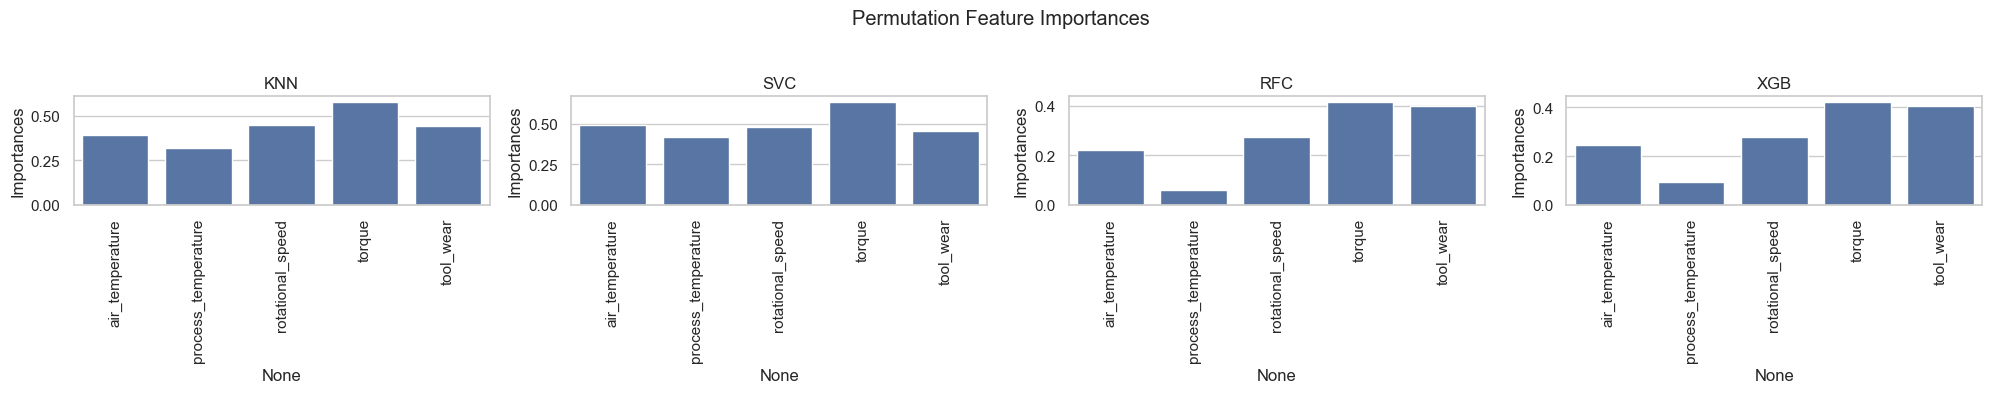

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.inspection import permutation_importance

# Define the custom F2 scorer
f2_scorer = make_scorer(fbeta_score, pos_label=1, beta=2)

# Initialize a DataFrame to hold feature importances
importances = pd.DataFrame()

# Calculate permutation feature importances for each classifier
for clf in fitted_models_binary:
    # Calculate permutation importance
    result = permutation_importance(clf, X_train, y_train['target'],
                                    scoring=f2_scorer, random_state=0)
    
    # Create a Series of mean importances
    result_mean = pd.Series(data=result.importances_mean, index=X.columns)
    
    # Concatenate results into the importances DataFrame
    importances = pd.concat(objs=[importances, result_mean], axis=1)

# Set column names to model names for clarity
importances.columns = classifier_names

# Create a bar plot for feature importances
fig, axs = plt.subplots(ncols=len(importances.columns), figsize=(20, 4))
fig.suptitle('Permutation Feature Importances')

for j, model_name in enumerate(importances.columns):
    sns.barplot(ax=axs[j], x=importances.index, y=importances[model_name].values)
    axs[j].tick_params(axis='x', labelrotation=90)
    axs[j].set_ylabel('Importances')
    axs[j].set_title(model_name)

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
plt.show()

### Multiclass modelling

/Users/admin/Documents/ml-portfolio/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation set metrics:
ACC    0.924
AUC    0.983
F1     0.906
F2     0.916
dtype: float64
Test set metrics:
ACC    0.921
AUC    0.980
F1     0.905
F2     0.914
dtype: float64


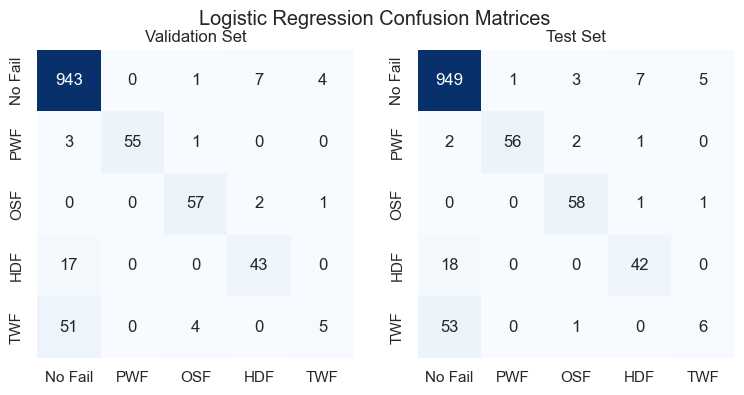

,air_temperature,process_temperature,rotational_speed,torque,tool_wear
No Failure,0.220314,2.886822,0.104200,0.056920,0.281201
Power Failure,0.868326,0.956252,951.714046,2876.538948,0.754706
Tool Wear Failure,0.288239,2.295452,0.195027,11.399975,366.087371
Overstrain Failure,4603.061515,0.004138,0.000442,0.403584,0.728477
Heat Dissipation Failure,1.309712,0.756614,0.223391,0.117080,736.491359


In [37]:
# Fit Logistic Regression model
lr = LogisticRegression(random_state=0, multi_class='ovr')
lr.fit(X_train, y_train['failure_type'])

# Make predictions on validation and test sets
y_val_lr = lr.predict(X_val)
y_test_lr = lr.predict(X_test)

# Evaluate and obtain validation metrics
cm_val_lr, metrics_val_lr = eval_preds(lr, X_val, y_val, y_val_lr, 'multi_class')
cm_test_lr, metrics_test_lr = eval_preds(lr, X_test, y_test, y_test_lr, 'multi_class')

# Print validation and test metrics
print('Validation set metrics:', metrics_val_lr, sep='\n')
print('Test set metrics:', metrics_test_lr, sep='\n')

# Prepare confusion matrices for visualization
cm_lr = [cm_val_lr, cm_test_lr]
cm_labels = ['No Fail', 'PWF', 'OSF', 'HDF', 'TWF']

# Plot confusion matrices
fig, axs = plt.subplots(ncols=2, figsize=(9, 4))
fig.suptitle('Logistic Regression Confusion Matrices')

for j, title in enumerate(['Validation Set', 'Test Set']):
    ax = axs[j]
    sns.heatmap(data=cm_lr[j], annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)

plt.show()

# Calculate odds for interpretation
odds_df = pd.DataFrame(data=np.exp(lr.coef_), columns=X_train.columns,
                       index=df_resampled['failure_type'].unique())

# Display odds DataFrame
odds_df

In [38]:
models = {
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(decision_function_shape='ovr'),
    'RFC': RandomForestClassifier(),
    'XGB': XGBClassifier()
}

# Define hyperparameters for each model
hyperparameters = {
    'KNN': {'n_neighbors': [1, 3, 5, 8, 10]},
    'SVC': {
        'C': [1, 10, 100],
        'gamma': [0.1, 1],
        'kernel': ['rbf'],
        'probability': [True],
        'random_state': [0]
    },
    'RFC': {
        'n_estimators': [100, 300, 500, 700],
        'max_depth': [5, 7, 10],
        'random_state': [0]
    },
    'XGB': {
        'n_estimators': [100, 300, 500],
        'max_depth': [5, 7, 10],
        'learning_rate': [0.01, 0.1],
        'objective': ['multi:softprob']
    }
}

# Tune hyperparameters for each model using GridSearch
print('Starting GridSearch for hyperparameter tuning...')
fitted_models_multi = []

for model_name, model in models.items():
    print(f'Training {model_name}...')
    
    # Call the function to tune and fit the model
    fitted_model = tune_and_fit(model, X_train, y_train, hyperparameters[model_name], 'multi_class')
    
    # Append the fitted model to the list
    fitted_models_multi.append(fitted_model)

print('GridSearch completed.')

Starting GridSearch for hyperparameter tuning...
Training KNN...
Grid search started
Best parameters: {'n_neighbors': 1}
Training time: 0m 2s
Training SVC...
Grid search started


/Users/admin/Documents/ml-portfolio/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf', 'probability': True, 'random_state': 0}
Training time: 1m 27s
Training RFC...
Grid search started
Best parameters: {'max_depth': 10, 'n_estimators': 700, 'random_state': 0}
Training time: 2m 58s
Training XGB...
Grid search started
Best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'objective': 'multi:softprob'}
Training time: 3m 54s
GridSearch completed.


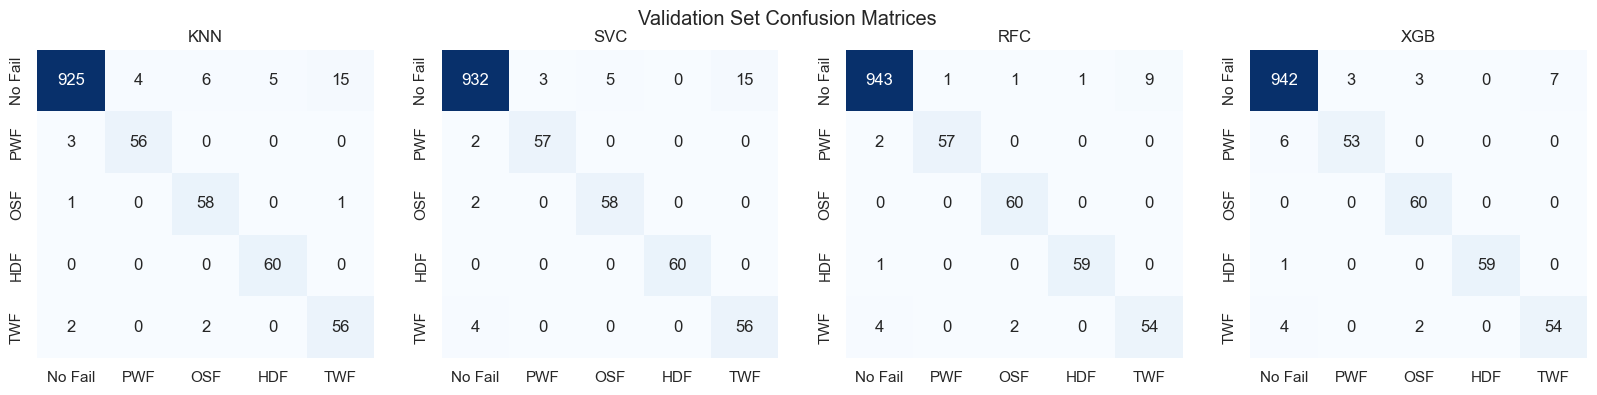

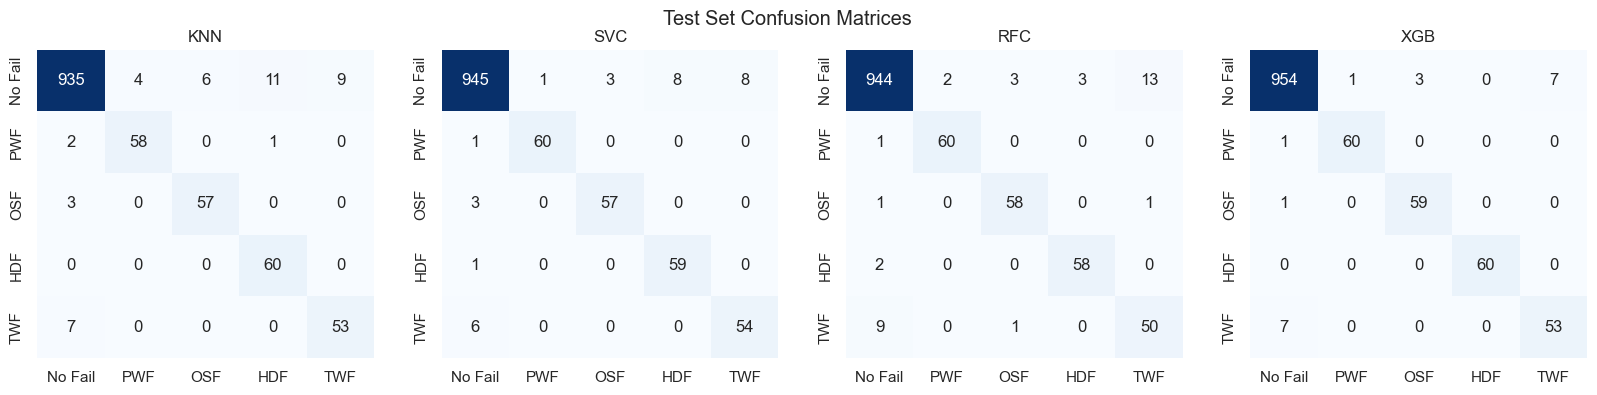


Validation scores:
       KNN    SVC    RFC    XGB
ACC  0.967  0.974  0.982  0.978
AUC  0.973  0.993  0.998  0.998
F1   0.968  0.975  0.983  0.978
F2   0.968  0.974  0.982  0.978
Test scores:
       KNN    SVC    RFC    XGB
ACC  0.964  0.974  0.970  0.983
AUC  0.962  0.993  0.997  0.998
F1   0.965  0.975  0.970  0.983
F2   0.964  0.974  0.970  0.983


In [39]:
# Define the task type
task = 'multi_class'

# Predict and evaluate for validation and test datasets
y_pred_val, cm_dict_val, metrics_val = predict_and_evaluate(
    fitted_models_multi, X_val, y_val, classifier_names, task
)
y_pred_test, cm_dict_test, metrics_test = predict_and_evaluate(
    fitted_models_multi, X_test, y_test, classifier_names, task
)

# Function to display confusion matrices
def plot_confusion_matrices(cm_dict, model_names, title):
    fig, axs = plt.subplots(ncols=len(model_names), figsize=(20, 4))
    fig.suptitle(title)
    
    for j, model_name in enumerate(model_names):
        ax = axs[j]
        sns.heatmap(ax=ax, data=cm_dict[model_name], annot=True,
                    fmt='d', cmap='Blues', cbar=False)
        ax.set_title(model_name)
        ax.set_xticklabels(cm_labels)
        ax.set_yticklabels(cm_labels)

    plt.show()

# Show Validation Confusion Matrices
plot_confusion_matrices(cm_dict_val, classifier_names, 'Validation Set Confusion Matrices')

# Show Test Confusion Matrices
plot_confusion_matrices(cm_dict_test, classifier_names, 'Test Set Confusion Matrices')

# Print evaluation scores for validation and test sets
print('\nValidation scores:', metrics_val, sep='\n')
print('Test scores:', metrics_test, sep='\n')

Evaluating feature importances for KNN...
Evaluating feature importances for SVC...
Evaluating feature importances for RFC...
Evaluating feature importances for XGB...


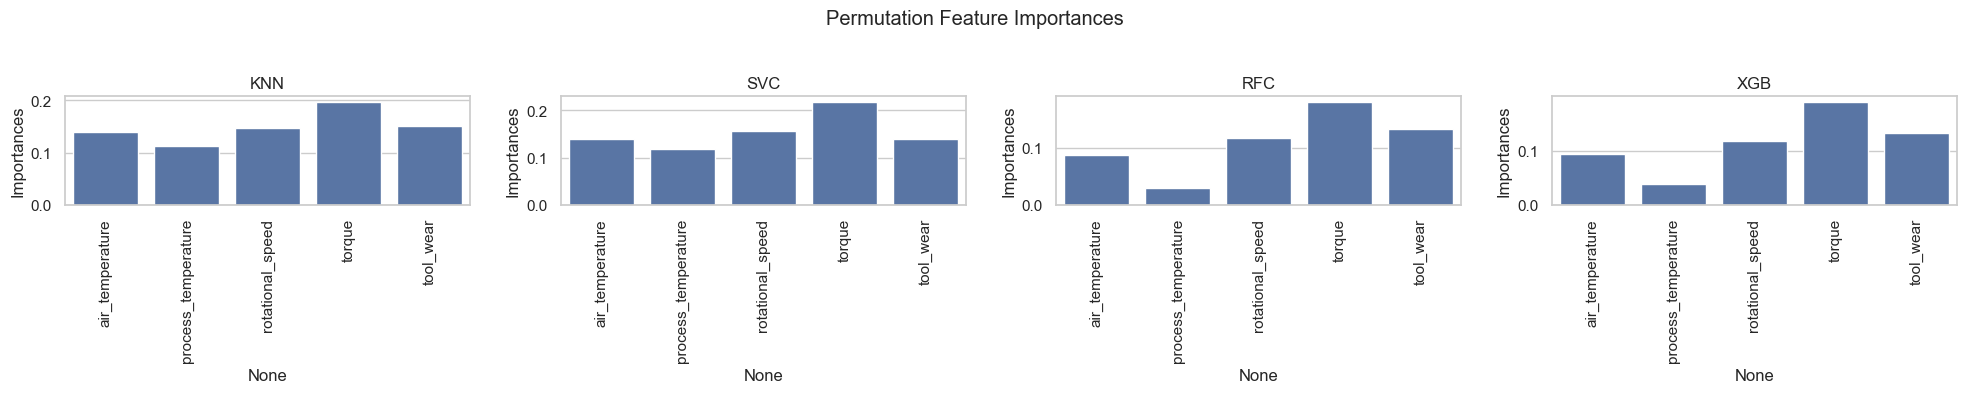

In [40]:
# Define the F2 scorer for evaluation
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

# Initialize DataFrame to store importances
importances = pd.DataFrame()

# Calculate permutation feature importances for each model
for clf, model_name in zip(fitted_models_multi, classifier_names):
    print(f'Evaluating feature importances for {model_name}...')
    
    # Calculate permutation importance
    result = permutation_importance(clf, X_train, y_train['failure_type'],
                                    scoring=f2_scorer, random_state=0)
    
    # Create a Series with the mean importances
    result_mean = pd.Series(data=result.importances_mean, index=X.columns)
    
    # Concatenate results into the importances DataFrame
    importances = pd.concat(objs=[importances, result_mean], axis=1)

# Set column names to model names
importances.columns = classifier_names

# Plotting the feature importances
fig, axs = plt.subplots(ncols=len(importances.columns), figsize=(20, 4))
fig.suptitle('Permutation Feature Importances')

for j, model_name in enumerate(importances.columns):
    ax = axs[j]
    sns.barplot(ax=ax, x=importances.index, y=importances[model_name].values)
    ax.tick_params(axis='x', labelrotation=90)  # Rotate x-axis labels for clarity
    ax.set_ylabel('Importances')
    ax.set_title(model_name)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
plt.show()

# Conclusion

This was a good experiment to understand the thought process behind classification tasks and to outline a working pipeline for tackling these problems.

In [41]:
## Saving the packages

import joblib

joblib.dump(fitted_models_binary[3], "xgb_model_binary.pkl")
joblib.dump(fitted_models_multi[3], "xgb_model_multi.pkl")


['xgb_model_multi.pkl']